<a href="https://colab.research.google.com/github/kirill-rubashevskiy/expf-statistics-ab/blob/main/bootstrap-vs-tests/bootstrap_vs_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Бутстрап vs t- и u-тесты

## Описание данных

- `value` – значения;
- `experimentVariant` – вариант теста:
    - `Control` – контроль;
    - `Treatment` – тест.

## Задача

Сравнить результаты:
- t-теста vs бутстрапа средних;
- u-теста vs бутстрапа медиан.

## Подготовка к работе

In [1]:
# импорт библиотек

# общие, работа с данными
import os
import six
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# визуализация данных
import seaborn as sns
import matplotlib.pyplot as plt

# статистическая проверка гипотез
from scipy.stats import norm, mannwhitneyu, ttest_ind

In [2]:
# настройка отображения графиков
plt.style.use('fivethirtyeight')

## Загрузка данных

In [3]:
# подключение google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# указание пути к данным
PATH = '/content/drive/MyDrive/expf/bootstrap-vs-tests'

In [5]:
# чтение данных
data = pd.read_csv(filepath_or_buffer = os.path.join(PATH, 'hw5.csv'),
                   sep                = ';',
                   index_col          = 0,
                   decimal            = ',')

In [6]:
# вывод на экран первых пяти строк датасета
data.head(5)

,value,experimentVariant
1,9.773113,Treatment
2,9.311246,Treatment
3,11.172828,Treatment
4,11.624510,Treatment
5,10.462331,Treatment


In [7]:
# вывод на экран общей информации о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 1 to 550
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   value              550 non-null    float64
 1   experimentVariant  550 non-null    object 
dtypes: float64(1), object(1)
memory usage: 12.9+ KB


## EDA

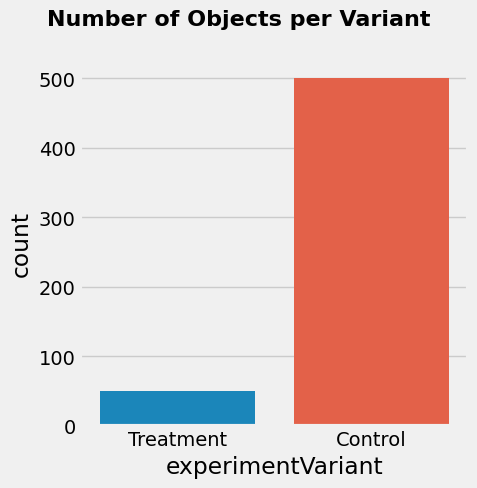

In [8]:
# вывод на экран графика количества объектов в каждом варианте теста
fig = plt.subplots(figsize = (5, 5))

sns.countplot(data = data,
              x    = 'experimentVariant')

plt.suptitle('Number of Objects per Variant', fontsize = 16, fontweight = 'bold')

plt.tight_layout()
plt.show()

- соотношение объектов в контрольном и тестовом вариантах 9 к 1
- в варианте `Treatment` меньше объектов, так что можно ожидать более широкий доверительный интервал значений value

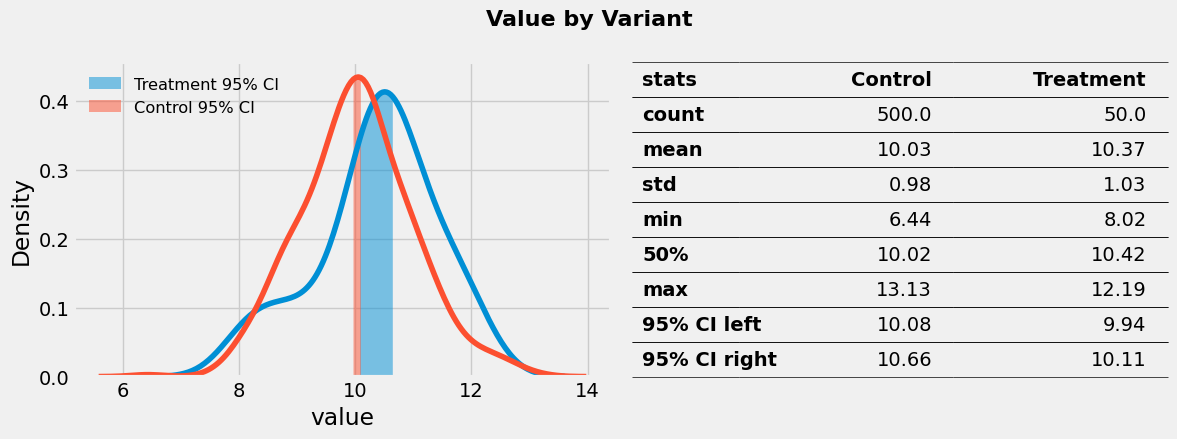

In [9]:
# вывод на экран графиков и статистик распределения значений
# в зависимости от варианта теста
fig, ax = plt.subplots(nrows   = 1,
                       ncols   = 2,
                       figsize = (12, 4.5))

ax = ax.flatten()

cis_left = []
cis_right = []

for variant in data.experimentVariant.unique():
    variant_data = data[data.experimentVariant == variant]
    mean_ = np.mean(variant_data.value)
    std_ = np.std(variant_data.value, ddof = 1)
    se_   = std_ / np.sqrt(len(variant_data))

    g = sns.kdeplot(data = variant_data,
                    x    = 'value',
                    ax = ax[0])

    x = g.lines[-1].get_xdata()
    y = g.lines[-1].get_ydata()

    ci_left = mean_ - se_ * 2
    ci_right = mean_ + se_ * 2

    cis_left.append(np.round(ci_left, 2))
    cis_right.append(np.round(ci_right, 2))

    g.fill_between(x,
                   y,
                   0,
                   where = (x > ci_left) & (x < ci_right),
                   alpha = 0.5,
                   label = f'{variant} 95% CI')

ax[0].legend(loc            = 'upper left',
             frameon        = False,
             fontsize       = 'small')

feature_stats = data.groupby('experimentVariant').value.describe().T.round(2).reset_index()
feature_stats.rename(columns = {'index' : 'stats'},
                     inplace = True)

feature_stats.loc[len(feature_stats.index)] = ['95% CI left'] + cis_left
feature_stats.loc[len(feature_stats.index)] = ['95% CI right'] + cis_right

feature_stats = feature_stats.iloc[[0, 1, 2, 3, 5, 7, 8, 9], :]

the_table = ax[1].table(cellText  = feature_stats.values,
                        colLabels = feature_stats.columns,
                        bbox      = (0, 0, 1, 1),
                        colWidths = [0.2, 0.4, 0.4],
                        edges     = 'horizontal')

the_table.auto_set_font_size(False)
the_table.set_fontsize(14)

for k, cell in six.iteritems(the_table._cells):
    if k[1] == 0: cell.set_text_props(ha = 'left')
    else: cell.set_text_props(ha = 'right')
    if k[0] == 0 or k[1] == 0: cell.set_text_props(weight = 'bold')

ax[1].axis('off')

fig.suptitle('Value by Variant',
             fontsize   = 16,
             fontweight = 'bold')

plt.tight_layout()
plt.show()

Мы видим, что:
- в обоих вариантах:
    - распределение значений value похоже на нормальное;
    - нет существенных выбросов;
- в тестовом варианте:
    - среднее и медиана и 95%-ый доверительный интервал больше (последнее объясняется более маленькой выборкой);
- 95%-ые доверительные интервалы немного пересекаются, но не значительно;
- распеределения значений value в обоих вариантах имеют схожую форму.

Также посмотрим, есть в каждом варианте часто повторяющиеся значения value:

In [10]:
# по каждому варианту вывод на экран количества уникальных значений value
data.groupby('experimentVariant')['value'].nunique().to_frame()

,value
experimentVariant,
Control,500
Treatment,50


В каждом варианте количество уникальных значений value равно количеству объектов, следовательно, часто повторяющихся значений нет.

## Статистическая проверка гипотез

При проведении статистической проверки гипотез будем использовать α = 0.05:

In [11]:
# сохранение константных значений в отдельные переменные
ALPHA = 0.05

In [12]:
# сохранение значений value по каждому варианту в отдельные переменные
control_data   = data[data.experimentVariant == 'Control'].value
treatment_data = data[data.experimentVariant == 'Treatment'].value

In [13]:
# создание таблицы tests_results для сохранения результатов тестов
tests_results = pd.DataFrame(
    index   = ['boot_mean',
               'ttest',
               'boot_median',
               'mannwhitneyu'],
    columns = ['p_value']
    )

### Бутстрап

Используем бутстрап для двух целей:
- убедимся, что средние двух вариантов нормально распределены;
- рассчитаем p-values для средних и медиан.

Для каждой из статистик сформулируем нулевую и альтернативную гипотезы:

- **нулевая гипотеза**: статистики значений value в контрольном и тестовом вариантах равны;
- **альтернативная гипотеза**: статистики значений value в контрольном и тестовом вариантах различаются.

In [14]:
# создание функции get_bootstrap
def get_bootstrap(
    data_0: list, # числовые значения первой выборки
    data_1: list, # числовые значения второй выборки
    boot_it: int = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    conf_level: float = 1 - ALPHA, # уровень значимости
):
    boot_data = []

    for _ in tqdm(range(boot_it)):
        boot_0 = data_0.sample(len(data_0), replace = True).values
        boot_1 = data_1.sample(len(data_1), replace = True).values
        boot_data.append(statistic(boot_0) - statistic(boot_1))

    orig_theta = statistic(data_0)-statistic(data_1) # разница в исходных данных
    boot_theta = np.mean(boot_data) # среднее по бутстрапированной разнице статистик
    delta_val  = boot_theta - orig_theta # дельта для сдвига
    boot_data  = [i - delta_val for i in boot_data]

    left_quant = (1 - conf_level)/2
    right_quant = 1 - (1 - conf_level) / 2
    ci = pd.DataFrame(boot_data).quantile([left_quant, right_quant])

    p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2

    return boot_data, p_value

In [15]:
# применение функции get_bootstrap для средних и медиан и сохранение результатов
# тестов
boot_data_mean, pval  = get_bootstrap(control_data, treatment_data)
tests_results.loc['boot_mean', 'p_value'] = pval

boot_data_median, pval  = get_bootstrap(control_data, treatment_data, statistic = np.median)
tests_results.loc['boot_median', 'p_value'] = pval

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

### t-тест

Чтобы использовать t-тест для сравнения средних необходимо, чтобы:
- в выборках не было выбросов, которые могут исказить результаты теста; и
- средние (и следовательно их разница) были нормально распределены.

В ходе EDA мы убедились, что выборки не содержат существенных выбросов.

Проанализируем распределение распределение разницы средних, полученное с использованием бутстрапа:

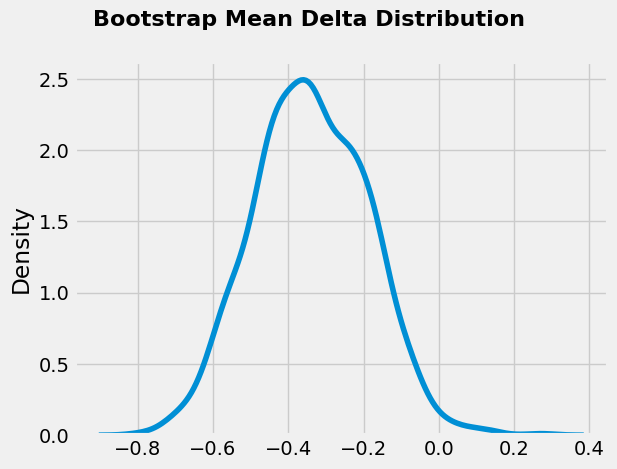

In [16]:
# вывод на экран графика распределения разницы средних,
# полученное в результате использованият бутстрапа

fig = plt.figure()
sns.kdeplot(boot_data_mean)

plt.suptitle('Bootstrap Mean Delta Distribution', fontsize = 16, fontweight = 'bold')

plt.tight_layout()
plt.show()

Разница средних похожа на нормальное распределение, можем проводить t-тест.

Сформулируем нулевую и альтернативную гипотезы:

- **нулевая гипотеза**: средние значения value в контрольном и тестовом вариантах равны;
- **альтернативная гипотеза**: средние значения value в контрольном и тестовом вариантах различаются.

In [17]:
# проведение t-теста
stat, pval = ttest_ind(control_data, treatment_data, equal_var = False)

# сохранение результатов в таблицу tests_results
tests_results.loc['ttest', 'p_value'] = pval

### u-тест

Чтобы использовать u-тест, необходимо, чтобы:
- не было много повторяющихся значений;
- распределения имели схожую форму.

Мы убедились, что оба условия выполнены, в ходе EDA, а значит можем перейти к проведению u-теста.

Сформулируем нулевую и альтернативную гипотезы:

- **нулевая гипотеза**: распределения значений value в контрольном и тестовом вариантах не содержат значимых различий;
- **альтернативная гипотеза**: распределения значений value в контрольном и тестовом вариантах значимо различаются.

In [18]:
# проведение u-теста
stat, pval = mannwhitneyu(control_data, treatment_data)

# сохранение результатов в таблицу tests_results
tests_results.loc['mannwhitneyu', 'p_value'] = pval

Проанализируем результаты тестов:

In [19]:
# вывод на экран результатов тестов
tests_results

,p_value
boot_mean,0.023655
ttest,0.029209
boot_median,0.000827
mannwhitneyu,0.005236


- **t-тест vs. бутстрап средних**:

    - p-values, полученные при помощи обоих тестов, примерно равны (разница начинается на 3 знаке после запятой)
    - на уровне значимости 95% мы можем отвергуть нулевую гипотезу о равенстве средних независимо от теста;

- **u-тест vs. бутстрап медиан**:

    - p-values, полученные при помощи обоих тестов, различаются в 10 раз, что может объясняться тем обстоятельством, что использованные тесты тестируют разные гипотезы (отвечают на разные вопросы);
    - на уровне значимости 95% мы может отвергнуть нулевые гипотезы обоих тестов.

## Общие выводы

В ходе работы над кейсом мы проанализировали данные, полученные в результате проведения A/B-теста, провели статистическую проверку гипотез с использованием бутстрапа и t- и u-тестов и сравнили полученные результаты.

**EDA**

- соотношение объектов в контрольном и тестовом вариантах 9 к 1
доверительный интервал значений value
- в обоих вариантах:
    - распределение значений value похоже на нормальное;
    - нет существенных выбросов;
- в тестовом варианте:
    - среднее и медиана и 95%-ый доверительный интервал больше (последнее объясняется более маленькой выборкой);
- 95%-ые доверительные интервалы немного пересекаются, но не значительно;
- распеределения значений value в обоих вариантах имеют схожую форму.

**Статистическая проверка гипотез**

*Бутстрап*

Мы использовали бутстрап для двух целей:
- убедиться, что средние двух вариантов нормально распределены;
- рассчитать p-values для средних и медиан.

Для каждой из статистик (среднее и медиана) мы сформулировали нулевую и альтернативную гипотезы:

- **нулевая гипотеза**: статистики значений value в контрольном и тестовом вариантах равны;
- **альтернативная гипотеза**: статистики значений value в контрольном и тестовом вариантах различаются.

*t-тест*

Мы убедились, что:

- разница средних похожа на нормальное распределение;
- выборки не содержат существенных выбросов.

Мы сформулировали нулевую и альтернативную гипотезы:

- **нулевая гипотеза**: средние значения value в контрольном и тестовом вариантах равны;
- **альтернативная гипотеза**: средние значения value в контрольном и тестовом вариантах различаются.

*u-тест*

Мы убедились, что:

- данные не содержат много повторяющихся значений;
- распределения имели схожую форму.

Мы сформулировали нулевую и альтернативную гипотезы:

- **нулевая гипотеза**: распределения значений value в контрольном и тестовом вариантах не содержат значимых различий;
- **альтернативная гипотеза**: распределения значений value в контрольном и тестовом вариантах значимо различаются.

*Сравнение результатов*

- **t-тест vs. бутстрап средних**:

    - p-values, полученные при помощи обоих тестов, примерно равны (разница начинается на 3 знаке после запятой)
    - на уровне значимости 95% мы можем отвергуть нулевую гипотезу о равенстве средних независимо от теста (в тестовом варианте наблюдается большее среднее);

- **u-тест vs. бутстрап медиан**:

    - p-values, полученные при помощи обоих тестов, различаются в 10 раз, что может объясняться тем обстоятельством, что использованные тесты тестируют разные гипотезы (отвечают на разные вопросы);
    - на уровне значимости 95% мы может отвергнуть нулевые гипотезы обоих тестов (в тестовом варианте наблюдается большая медиана, распределения значений value в контрольном и тестовом вариантах значимо различаются).